[  3.89385273e+04   9.73463184e-01]
9734.63


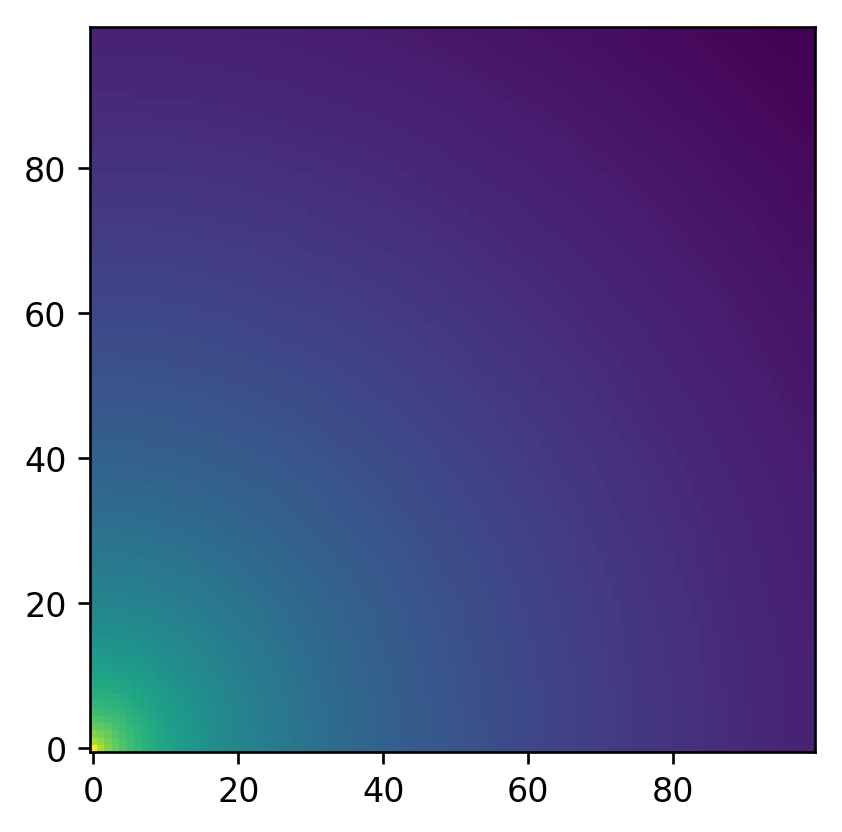

In [1]:
# This notebook demonstrates using pyprofit to fit an 8-component Gaussian 
# mixture model to an image of a Sersic model galaxy

# This is one method of determing weights for multi-Gaussian Sersics a la 
# Hogg & Lang 2013 

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyprofit as pyp
import galsim as gs

mpl.rcParams['figure.dpi'] = 240
mpl.rcParams['image.origin'] = 'lower'

# Make an image of a galaxy with a given Sersic index
## Plotting only the upper-right quadrant since it's round and symmetric

nx = 200
ny = nx
nser = 6.0
re = 5
band = ""
flux = nx*ny

img = gs.Sersic(flux=flux, n=nser, half_light_radius=re).drawImage(
    nx=nx, ny=ny, scale=1, method="real_space")
imgquad = img.array[(ny//2):ny, (nx//2):nx]
print(np.sum(img.array)/np.array([1, flux]))
print(np.sum(imgquad))
plt.imshow(np.log10(imgquad))
plt.show()

In [2]:
import pyprofit.python.objects as proobj
import pyprofit.python.util as proutil
ncomp = 8
offsetrefac = 1
refacmax = 0.5
fluxfracmod = 0

# Drawmethod fft will integrate over pixels; no_pixel will evaluate at center

model = proutil.getmodel(
	{band: flux}, "sersic:" + str(ncomp), imgquad.shape,
	sizes=np.power(re, np.linspace(
        offsetrefac-refacmax, offsetrefac+refacmax, ncomp)),
	axrats=np.repeat(1, ncomp),
	slopes=np.repeat(0.5, ncomp),
    engineopts={'drawmethod': 'fft', 'gsparams': gs.GSParams()})
for param in model.getparameters(fixed=False):
    if param.name == "cenx" or param.name == "ceny":
        param.setvalue(0)
        param.fixed = True
    elif param.name in ["nser", "axrat", "ang"]:
        param.fixed = True
    elif isinstance(param, proobj.FluxParameter):
        param.fixed = not param.isfluxratio
        if param.isfluxratio:
            param.setvalue(param.getvalue(transformed=True)+fluxfracmod, 
                           transformed=True)
    elif param.name == "re":
        print(param.getvalue())
# TODO: Think of a better way to incorporate sky-like background noise 
sigma = np.sqrt(imgquad + 1) 
proutil.setexposure(model, band, imgquad, 1.0/sigma)

print(["=".join([x.name, str(x.getvalue())]) for x in 
       model.getparameters(fixed=True)])

2.2360679775
2.81408920325
3.5415283093
4.45700966092
5.60914198127
7.05909929743
8.88386905829
11.1803398875
['cenx=0', 'ceny=0', 'flux=40000.0', 'flux=0.125', 're=2.2360679775', 'axrat=1.0', 'ang=0.0', 'nser=0.5', 'flux=0.142857142857', 're=2.81408920325', 'axrat=1.0', 'ang=0.0', 'nser=0.5', 'flux=0.166666666667', 're=3.5415283093', 'axrat=1.0', 'ang=0.0', 'nser=0.5', 'flux=0.2', 're=4.45700966092', 'axrat=1.0', 'ang=0.0', 'nser=0.5', 'flux=0.25', 're=5.60914198127', 'axrat=1.0', 'ang=0.0', 'nser=0.5', 'flux=0.333333333333', 're=7.05909929743', 'axrat=1.0', 'ang=0.0', 'nser=0.5', 'flux=0.5', 're=8.88386905829', 'axrat=1.0', 'ang=0.0', 'nser=0.5', 'flux=1.0', 're=11.1803398875', 'axrat=1.0', 'ang=0.0', 'nser=0.5']


-11528.6519744
[-1.9459101490553135, 0.34948500216800943, -1.791759469228055, 0.44933785993029773, -1.6094379124341005, 0.54919071769258621, -1.3862943611198906, 0.64904357545487468, -1.0986122886681098, 0.74889643321716304, -0.6931471805599454, 0.8487492909794514, 0.0, 0.94860214874173987, 1.0484550065040281]


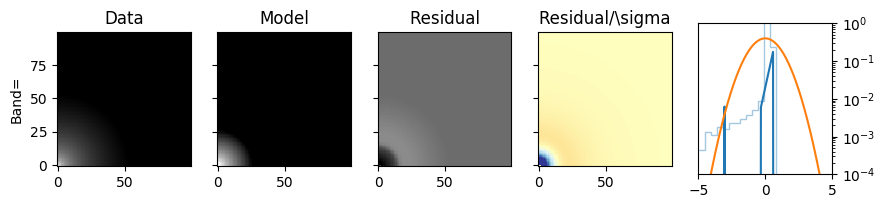

In [3]:
eval = model.evaluate(plot=True)
print(eval[0])
print(eval[1])
plt.show()

In [5]:
fit, modeller = proutil.fitmodel(model, modellib="pygmo", 
                                 printfinal=True, printsteps=100,
                                 modellibopts={'algo': 'neldermead'})

Param names:
 ['flux', 're', 'flux', 're', 'flux', 're', 'flux', 're', 'flux', 're', 'flux', 're', 'flux', 're', 're']
Initial parameters:
 [-1.94591015  0.349485   -1.79175947  0.44933786 -1.60943791  0.54919072
 -1.38629436  0.64904358 -1.09861229  0.74889643 -0.69314718  0.84874929
  0.          0.94860215  1.04845501]
Evaluating initial parameters:
 (-11528.651974377062, 0.0)


100 -9901.35240237 {'params': array([-1.8599638 ,  0.21502541, -1.82904991,  0.46360062, -3.30893407,
        1.08053433, -1.56439215,  1.03713246, -1.16297761,  1.22932388,
       -0.68079868,  1.50879898,  0.36459022,  0.2568226 ,  1.9358684 ]), 'likelihood': -9901.3524023718292, 'prior': 0.0}


200 -9224.50676846 {'params': array([-2.05782408,  0.19732463, -1.82647299,  0.47840886, -3.00506054,
        0.91001011, -1.5101614 ,  0.79868303, -1.24894164,  0.94735273,
       -0.61029787,  1.36840686,  0.07887441, -0.23641532,  2.05153384]), 'likelihood': -9224.506768456984, 'prior': 0.0}


300 -9200.8587077 {'params': array([-1.87940632,  0.18345439, -1.64205716,  0.51360538, -3.15929442,
        0.87675612, -1.50495112,  0.78136336, -1.16589085,  1.06938204,
       -0.58914804,  1.3814134 ,  0.23737852, -0.22116984,  2.11870398]), 'likelihood': -9200.8587077024276, 'prior': 0.0}


400 -9197.81402597 {'params': array([-1.70211426,  0.2319168 , -1.58474927,  0.54410431, -3.06648065,
        0.87459457, -1.466168  ,  0.82185291, -1.15883853,  1.10902254,
       -0.55313083,  1.41748974,  0.35201182, -0.22361417,  2.08862786]), 'likelihood': -9197.8140259665597, 'prior': 0.0}


500 -9195.92769831 {'params': array([-1.64686377,  0.22844493, -1.56827678,  0.56020338, -3.08554824,
        0.88704392, -1.4408721 ,  0.82580334, -1.15326472,  1.1060674 ,
       -0.56874924,  1.42128952,  0.35855339, -0.24648132,  2.08160507]), 'likelihood': -9195.9276983114032, 'prior': 0.0}


600 -9193.98233617 {'params': array([-1.54516598,  0.23621833, -1.49931852,  0.59612709, -3.14889133,
        0.96328839, -1.42334629,  0.84080426, -1.10740951,  1.115887  ,
       -0.62601087,  1.43704558,  0.418366  , -0.24420689,  1.99511396]), 'likelihood': -9193.9823361729723, 'prior': 0.0}


700 -9191.51907801 {'params': array([-1.65062738,  0.27260008, -1.26567564,  0.63373974, -3.05271517,
        0.91829446, -1.52298317,  0.91694214, -1.0743302 ,  1.18757457,
       -0.8176553 ,  1.4593121 ,  0.75677555, -0.20521457,  1.96272868]), 'likelihood': -9191.5190780053144, 'prior': 0.0}


800 -9190.35922654 {'params': array([-1.63567353,  0.284054  , -1.30575534,  0.63458284, -3.0232202 ,
        0.93325321, -1.53961893,  0.92684437, -1.08716749,  1.17726649,
       -0.84603859,  1.46820791,  0.80254268, -0.1860517 ,  1.93153029]), 'likelihood': -9190.3592265441966, 'prior': 0.0}


900 -9190.25355759 {'params': array([-1.64500295,  0.28351507, -1.31997693,  0.63031268, -3.0203406 ,
        0.93984037, -1.51612468,  0.91865367, -1.07728188,  1.17516066,
       -0.84646363,  1.47527123,  0.81351964, -0.18348772,  1.93276108]), 'likelihood': -9190.2535575900038, 'prior': 0.0}


1000 -9190.13510933 {'params': array([-1.6652935 ,  0.28420274, -1.36654787,  0.62309335, -2.97615017,
        0.9278201 , -1.46049554,  0.91119778, -1.05676804,  1.18131221,
       -0.84738129,  1.4839041 ,  0.84039348, -0.1834974 ,  1.93367516]), 'likelihood': -9190.13510933014, 'prior': 0.0}


1100 -9189.96683741 {'params': array([-1.70017283,  0.27052858, -1.46199224,  0.59553988, -3.00115537,
        0.95023681, -1.34845844,  0.87135994, -0.99501814,  1.17859888,
       -0.8368569 ,  1.4856735 ,  0.84041714, -0.18639031,  1.91527504]), 'likelihood': -9189.9668374058492, 'prior': 0.0}


1200 -9189.88984919 {'params': array([-1.7411895 ,  0.25990529, -1.5391492 ,  0.57128815, -3.01772601,
        0.96157971, -1.29135554,  0.84424029, -0.96730735,  1.16642605,
       -0.81573082,  1.47443063,  0.81516342, -0.19206191,  1.90698471]), 'likelihood': -9189.8898491857708, 'prior': 0.0}


1300 -9189.83201516 {'params': array([-1.80888766,  0.24818927, -1.53794431,  0.55465414, -3.05132121,
        0.96906953, -1.25941136,  0.83379504, -0.94350168,  1.16431789,
       -0.81621848,  1.47644114,  0.78956075, -0.19344168,  1.91125682]), 'likelihood': -9189.8320151607277, 'prior': 0.0}


Elapsed time: 363.6
Final likelihood: (-9189.824476828042, 0.0)
Parameter names:        flux      ,re        ,flux      ,re        ,flux      ,re        ,flux      ,re        ,flux      ,re        ,flux      ,re        ,flux      ,re        ,re        
Transformed parameters: -1.8133e+00,2.4611e-01,-1.5500e+00,5.5102e-01,-3.0579e+00,9.7306e-01,-1.2558e+00,8.2880e-01,-9.4356e-01,1.1597e+00,-8.1116e-01,1.4743e+00,7.8064e-01,-1.9459e-01,1.9115e+00


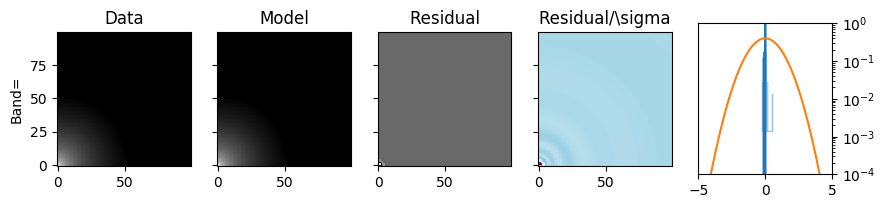

In [5]:
# TODO: Why is this plot so tiny??

model.evaluate(plot=True)
plt.show()

In [9]:
fluxes = []
varfracs = []
for param in model.getparameters(fixed=False):
    if isinstance(param, proobj.FluxParameter):
        if param.isfluxratio:
            fluxes.append(param.getvalue(transformed=False))
    elif param.name == "re":
        varfracs.append((param.getvalue(transformed=False)/re)**2)

print(fluxes)
fluxes.append(1)
flux = 1
for i in range(len(fluxes)):
    fluxes[i] *= flux
    flux -= fluxes[i]

print(fluxes)
print(varfracs)



[0.1372428012171811, 0.18938831652191063, 0.072593367848073492, 0.2163138783504947, 0.2782494105872822, 0.33385271750808698, 0.69570033922079444]
[0.1372428012171811, 0.16339613344463746, 0.050768975074715166, 0.14029947051234454, 0.14143212185161516, 0.12247737417012011, 0.17001742207837156, 0.074365701651014915]
[0.10706336272581687, 0.47583506085956651, 3.3678174087916886, 1.8067464655623182, 8.7207490909001706, 38.427099026706919, 0.014981710472941202, 313.71648828339602]
